In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new2 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  133885
number of successfully processed smiles:  133247


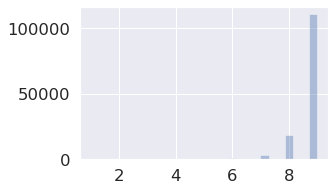

In [4]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/gdb9_smiles.csv"
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
#         print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.5
fingerprint_dim = 280

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
K = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [6]:
test_df = smiles_tasks_df.sample(frac=1/10, random_state=SEED) # test set
training_data = smiles_tasks_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
training_label_list = []
test_label_list = []
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    # the mean and standard deviation of training data is also used in test set
    test_df[task+'_normalized'] = (test_df[task]- mean)/std
    training_label_list.append(training_data[task+'_normalized'].values)
    test_label_list.append(test_df[task+'_normalized'].values)

training_label = np.array(training_label_list).astype(np.float).transpose()
test_label = np.array(test_label_list).astype(np.float).transpose()

    
# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=SEED) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

while (len(train_df) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


batch size:  503


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.708713,1.531956,1.191056,1.286217
1,alpha,75.190920,8.197607,6.308065,1.299544
2,homo,-0.239974,0.022176,0.016340,1.357178
3,lumo,0.011026,0.046912,0.038618,1.214779
4,gap,0.250999,0.047505,0.039648,1.198148
5,r2,1190.034973,279.648930,202.109506,1.383651
6,zpve,0.148522,0.033298,0.026472,1.257836
7,u0,-411.587569,40.087880,31.106651,1.288724
8,u298,-411.579095,40.087661,31.106518,1.288722
9,h298,-411.578151,40.087661,31.106518,1.288722


In [7]:
# # check the value distribution of different tasks
# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [8]:
# # check the distribution after normalization (should be the same)

# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task+"_normalized"].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [9]:
training_smiles = training_data['smiles'].values
test_smiles = test_df['smiles'].values
training_graph_dict = graph_dict(training_smiles, list(training_label), filename+'_training_seed'+str(SEED))
test_graph_dict = graph_dict(test_smiles, list(test_label), filename+'_test_seed'+str(SEED))
whole_graph_dict = {**training_graph_dict, **test_graph_dict}

graph dicts loaded from ../data/gdb9_smiles_training_seed28.pkl
graph dicts loaded from ../data/gdb9_smiles_test_seed28.pkl


In [10]:
ratio_array = torch.from_numpy(np.array(ratio_list).astype(np.float)).float()
ratio_array = ratio_array.to(device)
std_array = torch.from_numpy(np.array(std_list).astype(np.float)).float()
std_array = ratio_array.to(device)

ratio_array_square = ratio_array[None,:]**2
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

2936777
preprocess.0.linear.weight torch.Size([280, 39])
preprocess.0.linear.bias torch.Size([280])
preprocess.0.bn.weight torch.Size([280])
preprocess.0.bn.bias torch.Size([280])
encoder.0.linear.weight torch.Size([280, 49])
encoder.0.linear.bias torch.Size([280])
encoder.0.bn.weight torch.Size([280])
encoder.0.bn.bias torch.Size([280])
align.weight torch.Size([1, 560])
align.bias torch.Size([1])
attend.linear.weight torch.Size([280, 280])
attend.linear.bias torch.Size([280])
attend.bn.weight torch.Size([280])
attend.bn.bias torch.Size([280])
gru.weight_ih torch.Size([840, 280])
gru.weight_hh torch.Size([840, 280])
gru.bias_ih torch.Size([840])
gru.bias_hh torch.Size([840])
propagate.0.align.weight torch.Size([1, 560])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([280, 280])
propagate.0.attend.linear.bias torch.Size([280])
propagate.0.attend.bn.weight torch.Size([280])
propagate.0.attend.bn.bias torch.Size([280])
propagate.0.gru.weight_ih torch.Si

In [11]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device) * ratio_array_square # set STD/MAD ratio as the weights
        mol_prediction = model(atom, bond, bond_index, mol_index) * ratio_array_square
        
        loss = loss_function(mol_prediction.reshape(-1), label.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)


def eval(model, smiles_list):
    model.eval()
    eval_MAE_list = {}
    eval_MSE_list = {}
    y_val_list = {}
    y_pred_list = {}
    for i,task in enumerate(tasks):
        y_pred_list[task] = np.array([])
        y_val_list[task] = np.array([])
        eval_MAE_list[task] = np.array([])
        eval_MSE_list[task] = np.array([])
        
    eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]

            MAE = F.l1_loss(y_pred, label[:,i], reduction='none')        
            MSE = F.mse_loss(y_pred, label[:,i], reduction='none')
        
            y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
            y_val_list[task] = np.concatenate([y_val_list[task], label[:,i].cpu().detach().numpy()])
            eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
            eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
#     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
    eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MAE = np.multiply(eval_MAE_normalized, np.array(std_list))
    eval_RMSE_normalized = np.sqrt(np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)]))
    eval_RMSE = np.multiply(eval_RMSE_normalized, np.array(std_list))

    return eval_MAE_normalized, eval_MAE, eval_RMSE_normalized, eval_RMSE #, r2_score_list



In [ ]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 800
best_param["valid_MSE_normalized"] = 800
train_df_smiles = train_df.smiles.values
valid_df_smiles = valid_df.smiles.values

for epoch in range(300):
    losses = train(model, train_df_smiles)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df_smiles)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df_smiles)
    print("EPOCH:\t"+str(epoch)+' '+str(losses)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


212it [00:13, 17.19it/s]
212it [00:06, 32.93it/s]
27it [00:00, 36.59it/s]

EPOCH:	0 0.5741046395785404
train_MAE:
[7.80952222e-01 1.12073762e+00 8.46123282e-03 1.02877599e-02
 1.21683914e-02 5.72127470e+01 3.52494737e-03 4.63936317e+00
 5.73090726e+00 4.21646704e+00 6.02094474e+00 4.92395756e-01]
valid_MAE:
[7.70853665e-01 1.11977503e+00 8.40171382e-03 1.03908082e-02
 1.22586156e-02 5.75629112e+01 3.55284435e-03 4.66221160e+00
 5.75291295e+00 4.25719786e+00 6.03782636e+00 4.95980876e-01]
train_MSE_normalized_mean: 0.26799243955858243
valid_MSE_normalized_mean: 0.2651108161869623




212it [00:12, 18.66it/s]
212it [00:05, 41.65it/s]
27it [00:00, 39.70it/s]

EPOCH:	1 0.3262166417432281
train_MAE:
[7.31423440e-01 9.89267326e-01 7.84097631e-03 8.64271462e-03
 1.14556773e-02 5.23075990e+01 3.42764807e-03 4.45778814e+00
 4.13343212e+00 3.67996696e+00 4.23569510e+00 4.71041697e-01]
valid_MAE:
[7.25193167e-01 9.94689266e-01 7.85667610e-03 8.65433334e-03
 1.15023685e-02 5.23983255e+01 3.45291136e-03 4.49149911e+00
 4.17079414e+00 3.72138279e+00 4.26902961e+00 4.73477199e-01]
train_MSE_normalized_mean: 0.241450608794145
valid_MSE_normalized_mean: 0.24060332507000695




212it [00:12, 16.85it/s]
212it [00:05, 38.43it/s]
27it [00:00, 31.61it/s]

EPOCH:	2 0.2822828577515089
train_MAE:
[7.01136774e-01 1.05047451e+00 6.92883274e-03 8.92656063e-03
 1.13354606e-02 5.04410043e+01 4.47769648e-03 4.84097985e+00
 4.61278041e+00 4.68237546e+00 4.52706504e+00 5.11670917e-01]
valid_MAE:
[6.95206046e-01 1.05679040e+00 6.92628076e-03 8.91097201e-03
 1.13689986e-02 5.08531401e+01 4.50403555e-03 4.80804763e+00
 4.57565575e+00 4.65084724e+00 4.49439965e+00 5.12688617e-01]
train_MSE_normalized_mean: 0.24176211346700807
valid_MSE_normalized_mean: 0.24052606080271524




212it [00:12, 18.55it/s]
212it [00:06, 32.64it/s]
27it [00:00, 29.78it/s]

EPOCH:	3 0.26371901658064917
train_MAE:
[7.09742555e-01 1.59990263e+00 6.63967232e-03 1.02388508e-02
 1.21940670e-02 5.19853923e+01 5.31376656e-03 1.83393504e+00
 1.76084613e+00 1.80753957e+00 1.78422363e+00 6.61668728e-01]
valid_MAE:
[7.05117458e-01 1.59741567e+00 6.64968206e-03 1.02023842e-02
 1.22210959e-02 5.23630594e+01 5.32990299e-03 1.82547406e+00
 1.75234693e+00 1.80003103e+00 1.77630294e+00 6.61073947e-01]
train_MSE_normalized_mean: 0.22816013573950145
valid_MSE_normalized_mean: 0.22741808235038427




212it [00:13, 15.35it/s]
212it [00:05, 36.26it/s]
27it [00:00, 30.67it/s]

EPOCH:	4 0.2508669213725711
train_MAE:
[6.69326106e-01 1.07101302e+00 6.58195308e-03 8.35834133e-03
 1.05644588e-02 4.53627054e+01 2.55039815e-03 2.62177651e+00
 2.62850817e+00 2.58761370e+00 2.51773933e+00 4.38516859e-01]
valid_MAE:
[6.62925306e-01 1.07217018e+00 6.59666058e-03 8.36768878e-03
 1.06545979e-02 4.58216425e+01 2.55478975e-03 2.63012623e+00
 2.63812298e+00 2.60180687e+00 2.53029152e+00 4.39399612e-01]
train_MSE_normalized_mean: 0.20755883365479041
valid_MSE_normalized_mean: 0.20710888551584739




212it [00:12, 19.44it/s]
212it [00:05, 36.51it/s]
27it [00:00, 29.67it/s]

EPOCH:	5 0.24450787894849507
train_MAE:
[6.70877981e-01 7.76137823e-01 6.41098875e-03 8.17705809e-03
 9.77101910e-03 4.74556789e+01 2.49996242e-03 1.67854947e+00
 1.66470762e+00 1.68790512e+00 1.70409897e+00 4.10959645e-01]
valid_MAE:
[6.67624161e-01 7.79648813e-01 6.41602318e-03 8.17451242e-03
 9.82302709e-03 4.78259461e+01 2.51730341e-03 1.68265067e+00
 1.66911531e+00 1.69009550e+00 1.70619286e+00 4.10808601e-01]
train_MSE_normalized_mean: 0.19408631307197133
valid_MSE_normalized_mean: 0.1932981304691693




212it [00:12, 17.84it/s]
212it [00:06, 35.30it/s]
27it [00:00, 29.19it/s]

EPOCH:	6 0.23503148344890126
train_MAE:
[6.66983565e-01 8.78265831e-01 6.18299578e-03 7.57901698e-03
 9.73672237e-03 4.38674380e+01 2.42974560e-03 2.82676668e+00
 2.83536183e+00 2.81393144e+00 2.79374424e+00 5.70206183e-01]
valid_MAE:
[6.60529136e-01 8.82626340e-01 6.23764362e-03 7.52689353e-03
 9.78529232e-03 4.39606928e+01 2.42800362e-03 2.84136588e+00
 2.84937685e+00 2.82942387e+00 2.80886946e+00 5.72457755e-01]
train_MSE_normalized_mean: 0.20365499741463353
valid_MSE_normalized_mean: 0.20317168113100645




212it [00:12, 18.40it/s]
212it [00:06, 34.93it/s]
27it [00:00, 35.53it/s]

EPOCH:	7 0.22725549059094124
train_MAE:
[6.75045238e-01 7.44035983e-01 6.01695315e-03 7.11137779e-03
 8.88837673e-03 4.58956941e+01 1.96687345e-03 3.07188768e+00
 3.03748551e+00 3.03031065e+00 3.02658631e+00 3.85155435e-01]
valid_MAE:
[6.72869415e-01 7.43868182e-01 6.04326617e-03 7.12854548e-03
 8.95480059e-03 4.60408231e+01 1.98307117e-03 3.06834996e+00
 3.03383463e+00 3.02797994e+00 3.02418192e+00 3.86332070e-01]
train_MSE_normalized_mean: 0.19298939242398935
valid_MSE_normalized_mean: 0.19237793671911207




212it [00:12, 16.43it/s]
212it [00:06, 39.62it/s]
27it [00:00, 31.71it/s]

EPOCH:	8 0.22097734375944678
train_MAE:
[6.25446074e-01 6.98161716e-01 5.89997709e-03 6.92864151e-03
 8.88695367e-03 4.10989327e+01 2.43010274e-03 1.22775718e+00
 1.23210861e+00 1.24756441e+00 1.23969491e+00 4.23705970e-01]
valid_MAE:
[6.26628460e-01 7.00697971e-01 5.97290277e-03 6.92746598e-03
 8.95210170e-03 4.15069722e+01 2.45353387e-03 1.22607986e+00
 1.23055600e+00 1.24633127e+00 1.23865081e+00 4.25131191e-01]
train_MSE_normalized_mean: 0.17447145983048193
valid_MSE_normalized_mean: 0.1746965249577571




212it [00:13, 15.81it/s]
212it [00:06, 37.86it/s]
27it [00:00, 32.46it/s]

EPOCH:	9 0.21548862987250653
train_MAE:
[6.08181770e-01 7.74604006e-01 5.98711341e-03 7.80762154e-03
 8.84014839e-03 4.22277077e+01 1.93995930e-03 2.17415907e+00
 2.18115690e+00 2.16429396e+00 2.16590706e+00 4.09764003e-01]
valid_MAE:
[6.11320802e-01 7.80533091e-01 6.08175047e-03 7.83737681e-03
 8.91593696e-03 4.26759333e+01 1.97340949e-03 2.20129205e+00
 2.20827713e+00 2.19164287e+00 2.19322808e+00 4.09813929e-01]
train_MSE_normalized_mean: 0.18345803902207636
valid_MSE_normalized_mean: 0.1843323255510071




212it [00:12, 16.34it/s]
212it [00:05, 35.33it/s]
27it [00:00, 36.13it/s]

EPOCH:	10 0.21076815715938244
train_MAE:
[5.98948520e-01 9.75153129e-01 6.10090353e-03 7.14571452e-03
 8.29053094e-03 4.54987110e+01 3.06076108e-03 2.48588048e+00
 2.48280922e+00 2.46496057e+00 2.46865973e+00 5.34201574e-01]
valid_MAE:
[6.00059062e-01 9.75865179e-01 6.12461750e-03 7.09613193e-03
 8.33595922e-03 4.58240336e+01 3.07099148e-03 2.47076753e+00
 2.46773709e+00 2.45129698e+00 2.45494869e+00 5.34419643e-01]
train_MSE_normalized_mean: 0.18964603547714912
valid_MSE_normalized_mean: 0.1898812902532352




212it [00:12, 16.40it/s]
212it [00:05, 36.17it/s]
27it [00:00, 34.21it/s]

EPOCH:	11 0.20738924688325738
train_MAE:
[5.97103064e-01 9.50031204e-01 5.58265406e-03 7.03016256e-03
 8.51188664e-03 4.62394463e+01 2.35865662e-03 3.18379005e+00
 3.17664357e+00 3.14252556e+00 3.14493915e+00 5.21884390e-01]
valid_MAE:
[5.98974624e-01 9.50249007e-01 5.62343138e-03 7.02264988e-03
 8.64800776e-03 4.65382364e+01 2.37897291e-03 3.19793254e+00
 3.19070899e+00 3.15718010e+00 3.15946784e+00 5.25682983e-01]
train_MSE_normalized_mean: 0.19345545038539483
valid_MSE_normalized_mean: 0.19455704527742523




212it [00:13, 16.29it/s]
212it [00:05, 37.07it/s]
27it [00:00, 33.13it/s]

EPOCH:	12 0.20286077738932842
train_MAE:
[6.00733958e-01 6.34071924e-01 5.51755801e-03 6.25889127e-03
 8.13082588e-03 3.83997107e+01 2.70333177e-03 1.99963350e+00
 2.00489069e+00 2.02652181e+00 2.02258323e+00 3.60561769e-01]
valid_MAE:
[6.05860384e-01 6.41027666e-01 5.61691069e-03 6.26358268e-03
 8.24944132e-03 3.89534846e+01 2.71994962e-03 1.99655414e+00
 2.00154988e+00 2.02180712e+00 2.01808240e+00 3.62514941e-01]
train_MSE_normalized_mean: 0.17125900428868515
valid_MSE_normalized_mean: 0.17228722065990984




212it [00:13, 17.87it/s]
212it [00:06, 31.87it/s]
27it [00:00, 27.80it/s]

EPOCH:	13 0.19892747580723943
train_MAE:
[5.95221793e-01 7.00956176e-01 5.79726381e-03 5.89582366e-03
 8.13065949e-03 3.76753452e+01 2.04346087e-03 1.18969425e+00
 1.19294419e+00 1.20208811e+00 1.20053280e+00 3.43514310e-01]
valid_MAE:
[5.97496667e-01 6.98836467e-01 5.89653446e-03 5.86883224e-03
 8.23630257e-03 3.81810371e+01 2.05165918e-03 1.19671207e+00
 1.19993198e+00 1.20898864e+00 1.20749113e+00 3.46458007e-01]
train_MSE_normalized_mean: 0.16132089125782126
valid_MSE_normalized_mean: 0.16224771847076672




212it [00:13, 17.90it/s]
212it [00:05, 35.03it/s]
27it [00:00, 18.39it/s]

EPOCH:	14 0.19602489190281563
train_MAE:
[5.82999860e-01 7.54531388e-01 5.34014665e-03 6.90020806e-03
 8.06605845e-03 3.76875593e+01 2.22447465e-03 2.78878015e+00
 2.78575380e+00 2.76466921e+00 2.76811268e+00 3.57493403e-01]
valid_MAE:
[5.85941117e-01 7.58618008e-01 5.45942687e-03 6.90387714e-03
 8.16302477e-03 3.83473903e+01 2.24726772e-03 2.79519049e+00
 2.79229305e+00 2.77217684e+00 2.77553880e+00 3.58955013e-01]
train_MSE_normalized_mean: 0.17523014216583796
valid_MSE_normalized_mean: 0.1765937888833142




212it [00:12, 16.45it/s]
212it [00:05, 39.16it/s]
27it [00:00, 32.90it/s]

EPOCH:	15 0.19312039172311998
train_MAE:
[5.82989872e-01 6.35999110e-01 5.22441887e-03 6.28712533e-03
 7.94850719e-03 3.93403150e+01 2.05861662e-03 2.04815633e+00
 2.04615157e+00 2.03590902e+00 2.03644772e+00 3.85948973e-01]
valid_MAE:
[5.87220452e-01 6.48749493e-01 5.34268035e-03 6.26065710e-03
 8.07492692e-03 4.00598100e+01 2.07361319e-03 2.04815954e+00
 2.04629167e+00 2.03712442e+00 2.03756423e+00 3.88616240e-01]
train_MSE_normalized_mean: 0.1681440972330659
valid_MSE_normalized_mean: 0.16990303824257544




212it [00:13, 16.17it/s]
212it [00:05, 40.92it/s]
27it [00:00, 32.03it/s]

EPOCH:	16 0.19116627242205278
train_MAE:
[5.75178007e-01 6.59257133e-01 5.35992878e-03 6.03980171e-03
 7.72180839e-03 4.24055796e+01 1.91174933e-03 1.10344629e+00
 1.10295847e+00 1.10238506e+00 1.10211918e+00 3.04125032e-01]
valid_MAE:
[5.76766107e-01 6.65401425e-01 5.48801887e-03 6.04774908e-03
 7.87058638e-03 4.32548972e+01 1.91367645e-03 1.10799669e+00
 1.10741979e+00 1.10589367e+00 1.10569841e+00 3.05823035e-01]
train_MSE_normalized_mean: 0.15642266450028533
valid_MSE_normalized_mean: 0.15816299123156147




212it [00:13, 18.37it/s]
212it [00:05, 39.65it/s]
27it [00:00, 28.39it/s]

EPOCH:	17 0.18814633519582027
train_MAE:
[5.56501998e-01 6.52416549e-01 5.30154634e-03 5.76606483e-03
 7.64842242e-03 3.90485807e+01 1.66996347e-03 1.70710360e+00
 1.70847957e+00 1.71618053e+00 1.71566257e+00 3.51162161e-01]
valid_MAE:
[5.63047344e-01 6.60503633e-01 5.42756746e-03 5.79548205e-03
 7.81071522e-03 3.97311958e+01 1.67723941e-03 1.71694610e+00
 1.71824274e+00 1.72585181e+00 1.72534137e+00 3.55636962e-01]
train_MSE_normalized_mean: 0.1597997624846733
valid_MSE_normalized_mean: 0.16197148410803117




212it [00:13, 17.71it/s]
212it [00:05, 36.17it/s]
27it [00:01, 26.55it/s]

EPOCH:	18 0.18518880129141627
train_MAE:
[5.53054338e-01 8.38467885e-01 5.05243854e-03 5.82483783e-03
 7.40969629e-03 3.87600816e+01 2.30340950e-03 1.67068342e+00
 1.67000241e+00 1.65963234e+00 1.66101191e+00 4.03950028e-01]
valid_MAE:
[5.61152698e-01 8.41221067e-01 5.20875750e-03 5.86380714e-03
 7.53559629e-03 3.95504769e+01 2.31754417e-03 1.67630273e+00
 1.67566955e+00 1.66569537e+00 1.66701760e+00 4.04324925e-01]
train_MSE_normalized_mean: 0.1620064749678167
valid_MSE_normalized_mean: 0.16476611251652098




212it [00:12, 16.41it/s]
212it [00:06, 34.34it/s]
27it [00:00, 35.48it/s]

EPOCH:	19 0.184075533992277
train_MAE:
[5.47795579e-01 6.64830802e-01 4.90349697e-03 6.09062572e-03
 7.65904629e-03 3.46599136e+01 1.83431315e-03 3.09045866e+00
 3.09267009e+00 3.10172717e+00 3.10121621e+00 3.03340729e-01]
valid_MAE:
[5.56247916e-01 6.68140014e-01 5.03155956e-03 6.10948767e-03
 7.80380058e-03 3.53740819e+01 1.83725667e-03 3.09306432e+00
 3.09521674e+00 3.10376975e+00 3.10330937e+00 3.04374858e-01]
train_MSE_normalized_mean: 0.1658201958855712
valid_MSE_normalized_mean: 0.16821958762662234




191it [00:11, 15.72it/s]

mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [ ]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )